In [2]:
import pandas as pd
import numpy as np

def loader():
    """Reading data from keys"""
    with open("data/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data/data_{}.csv".format(str(key)))

    return dictex

In [12]:
df = loader()

In [4]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import nan, nanmean, isnan
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df

def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, len(X), 1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

def getValues(data):
    data.set_index("Date Time", inplace=True)
    included = np.array(data[INDEPENDENT_FEATURES].notnull().all(axis=1))

    float_data = data.loc[included, ['surf_temp_sqerror']].values.astype(np.float)

    nmean = nanmean(float_data)
    where_are_NaNs = isnan(float_data)
    float_data[where_are_NaNs] = 0
    return float_data


In [14]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

def plotPredictions(key, true, predictions):
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    pyplot.scatter(true, predictions, color="red", alpha=0.5, s=10)
    pyplot.xlim(0,20)
    pyplot.ylim(0,20)
    pyplot.plot(range(60), color='black', alpha=0.2)
    pyplot.grid()
    pyplot.title(key, fontsize=16)
    pyplot.xlabel('surf_temp_sqerror')
    pyplot.ylabel('Estimated surf_temp_sqerror')

In [15]:
def experiment(repeats, data, features, timesteps, key):
    float_data = getValues(data)
    diff_values = difference(float_data, features)
    supervised = timeseries_to_supervised(diff_values, timesteps)
    supervised_values = supervised.values[features:,:]
    print(int(len(float_data) * .3))
    train, test = supervised_values[0:-int(len(float_data) * .3), :], supervised_values[-int(len(float_data) * .3):, :]
    scaler, train_scaled, test_scaled = scale(train, test)
    
    error_scores = list()
    results = pd.DataFrame()
    for r in range(repeats):
        lstm_model = fit_lstm(train_scaled, 1, 10, 10)
        
        predictions = list()
        true = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            y = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(float_data, yhat, len(test_scaled)+1-i)
            y = inverse_difference(float_data, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
            true.append(y)
        # report performance
        mse = mean_squared_error(float_data[-int(len(float_data) * .3):], predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        plotPredictions(key, true, predictions)
    return error_scores

942
1) Test MSE: 0.243
2) Test MSE: 0.238
3) Test MSE: 0.252
4) Test MSE: 0.254
5) Test MSE: 0.249
6) Test MSE: 0.250
7) Test MSE: 0.252
8) Test MSE: 0.236
9) Test MSE: 0.240
10) Test MSE: 0.245
942
1) Test MSE: 8.516
2) Test MSE: 8.772
3) Test MSE: 9.802
4) Test MSE: 9.015
5) Test MSE: 8.383
6) Test MSE: 8.563
7) Test MSE: 9.911
8) Test MSE: 9.296
9) Test MSE: 8.550
10) Test MSE: 8084.205
942
1) Test MSE: 5.787
2) Test MSE: 6.151
3) Test MSE: 5.912
4) Test MSE: 6.038
5) Test MSE: 5.954
6) Test MSE: 6.026
7) Test MSE: 6.156
8) Test MSE: 6.031
9) Test MSE: 5.936
10) Test MSE: 5.885
942
1) Test MSE: 6.512
2) Test MSE: 10.465
3) Test MSE: 6.978
4) Test MSE: 6.568
5) Test MSE: 235.585
6) Test MSE: 6.641
7) Test MSE: 6.225
8) Test MSE: 8.571
9) Test MSE: 9.435
10) Test MSE: 22.749
942
1) Test MSE: 0.112
2) Test MSE: 0.109
3) Test MSE: 0.116
4) Test MSE: 0.112
5) Test MSE: 0.117
6) Test MSE: 0.114
7) Test MSE: 0.112
8) Test MSE: 0.112
9) Test MSE: 0.111
10) Test MSE: 0.113
942
1) Test MSE: 2

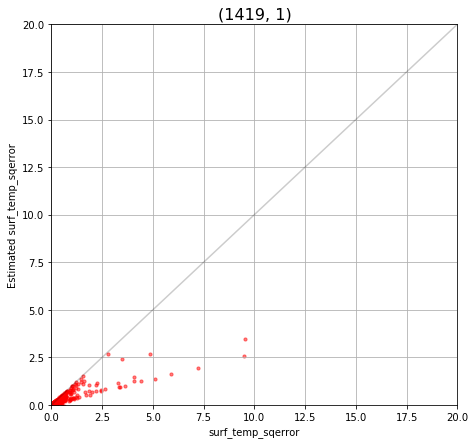

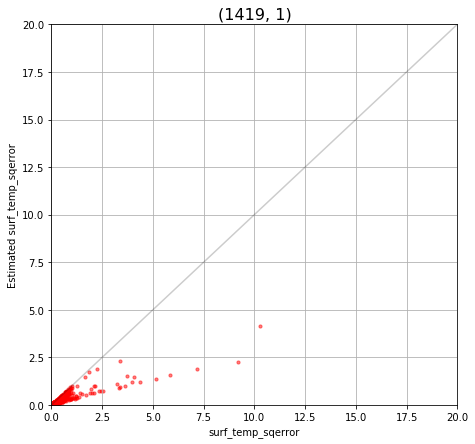

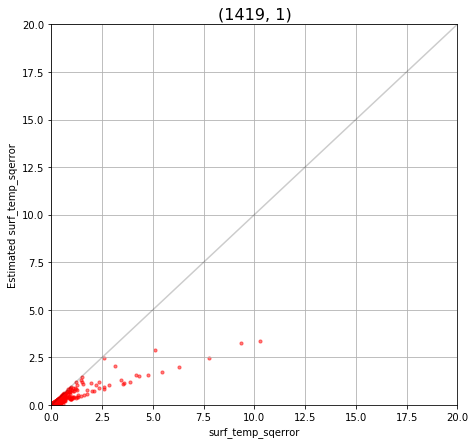

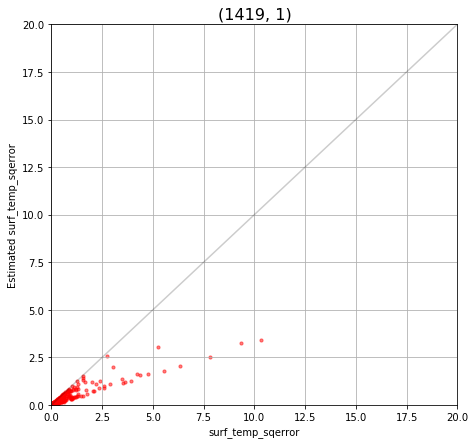

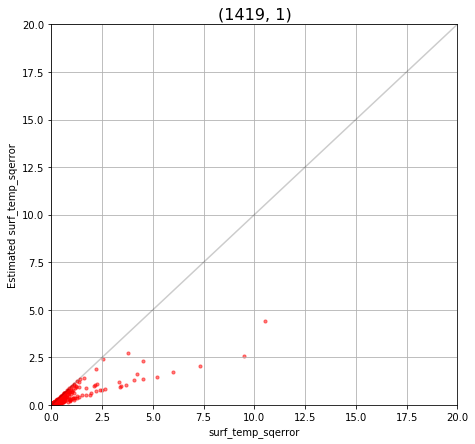

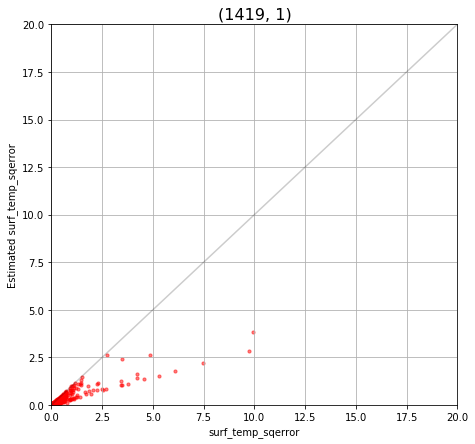

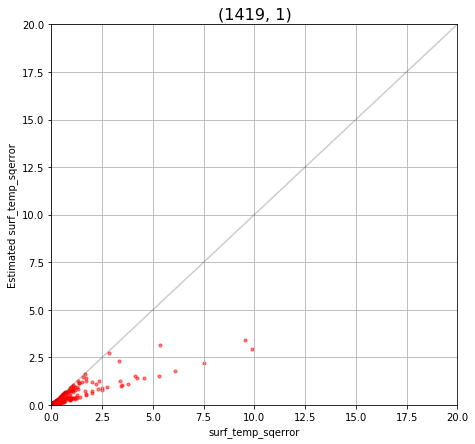

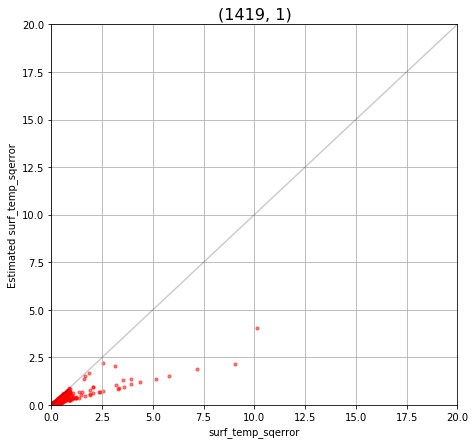

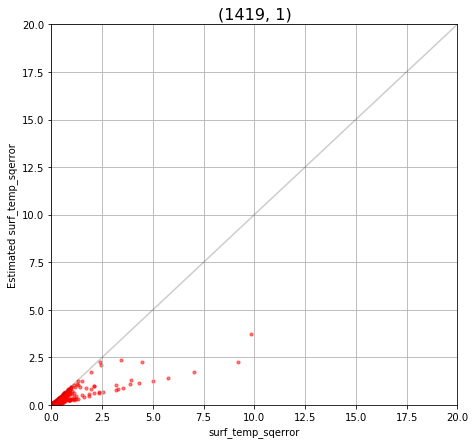

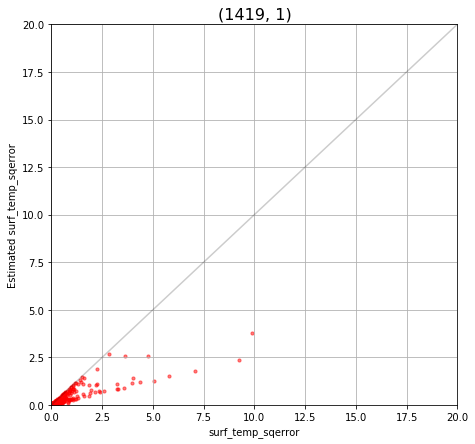

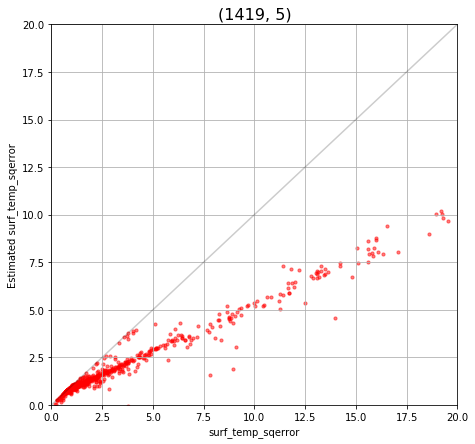

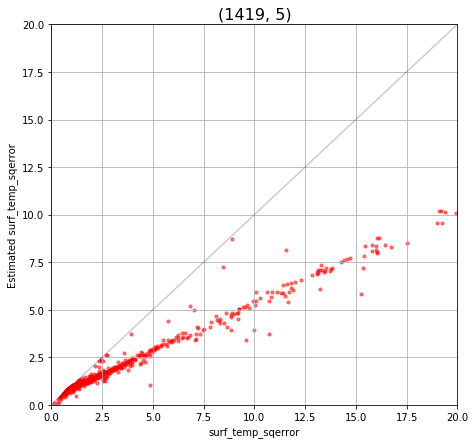

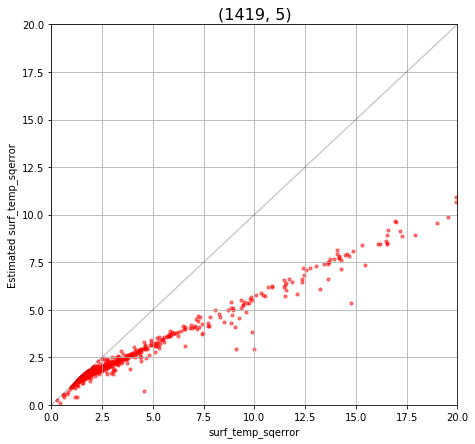

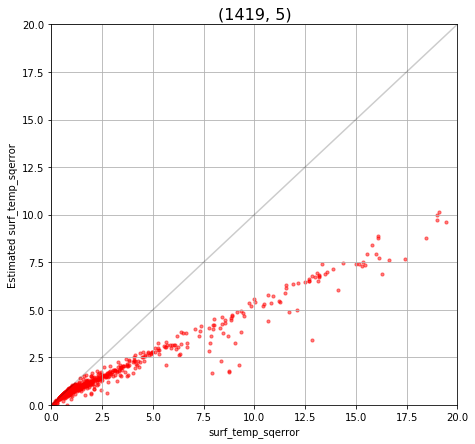

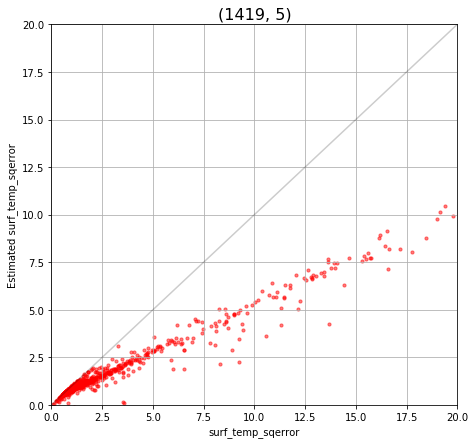

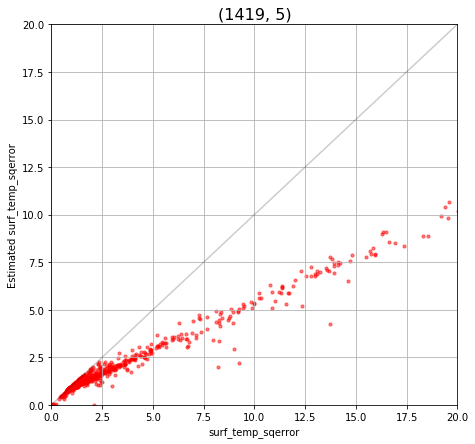

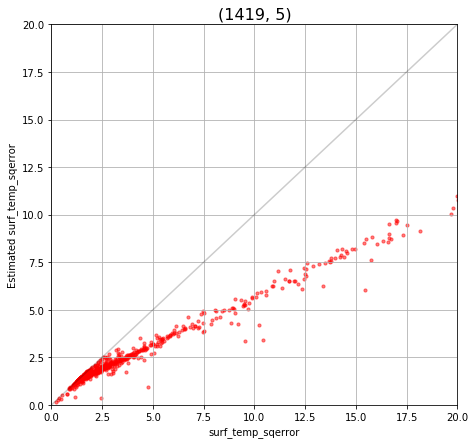

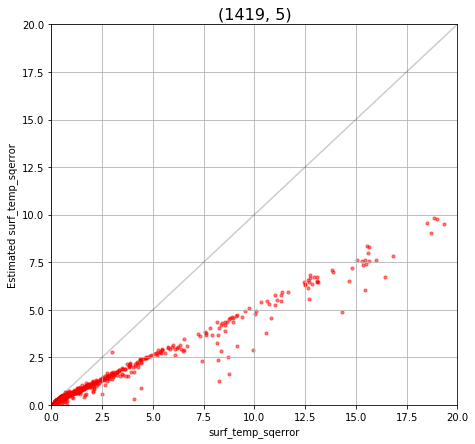

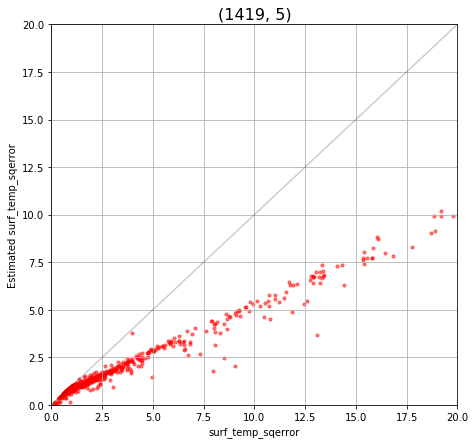

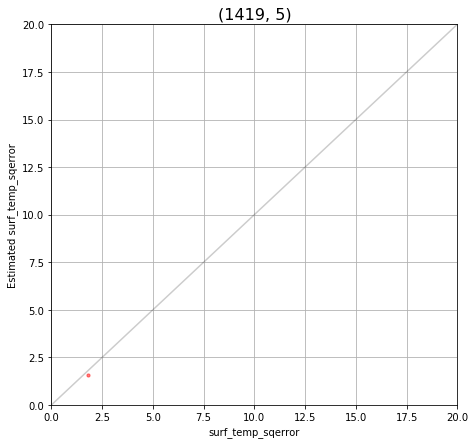

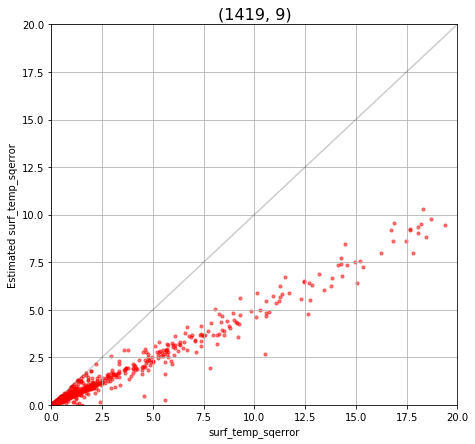

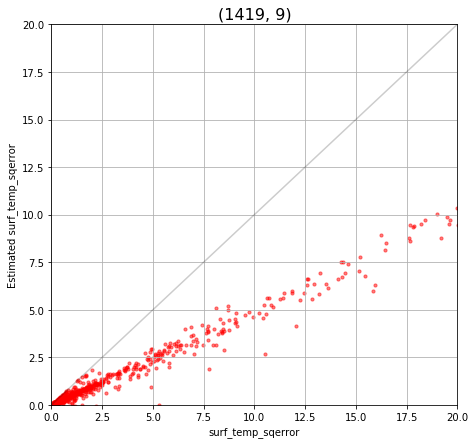

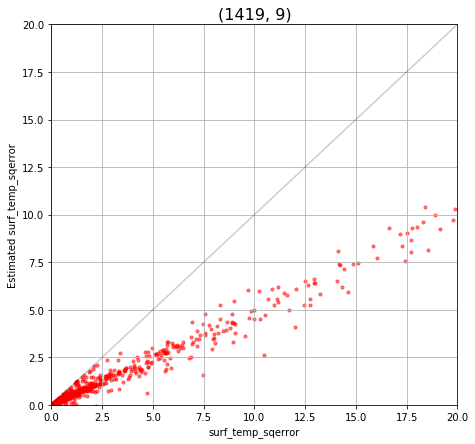

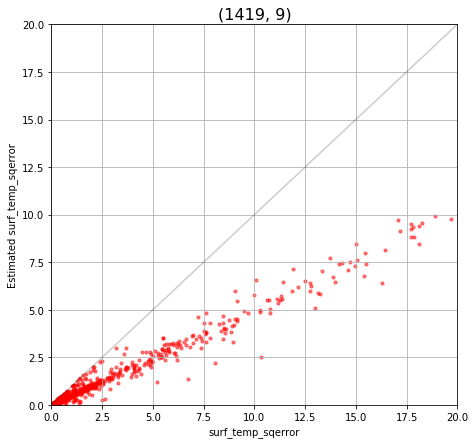

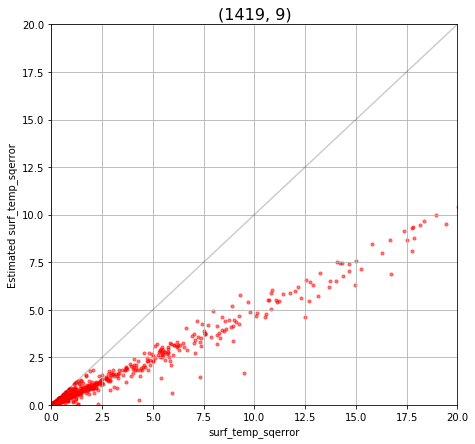

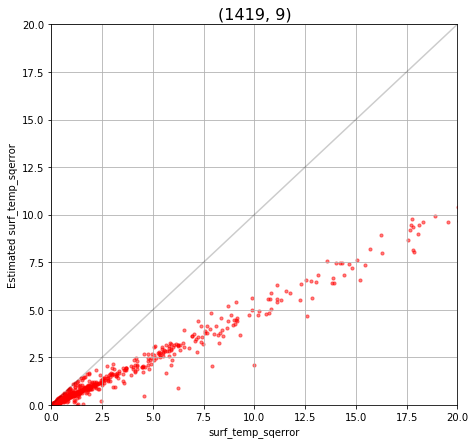

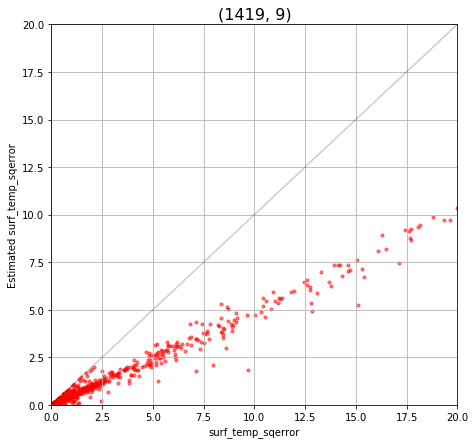

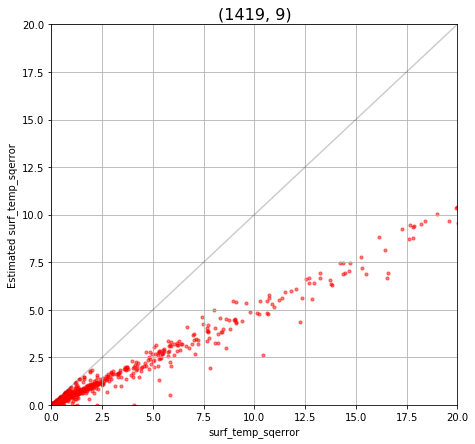

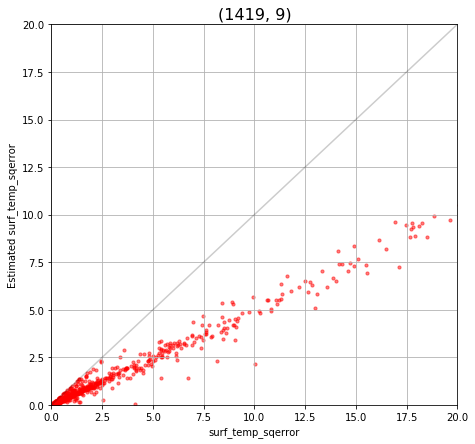

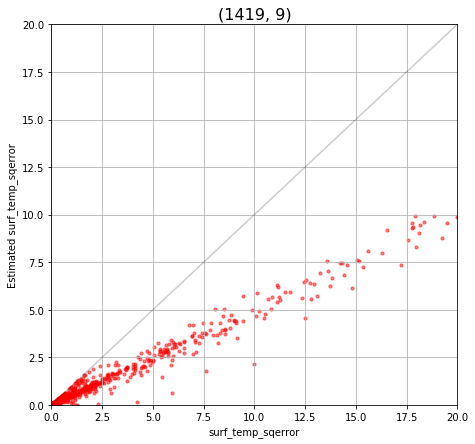

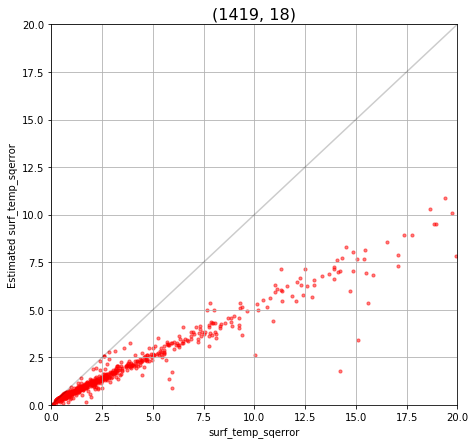

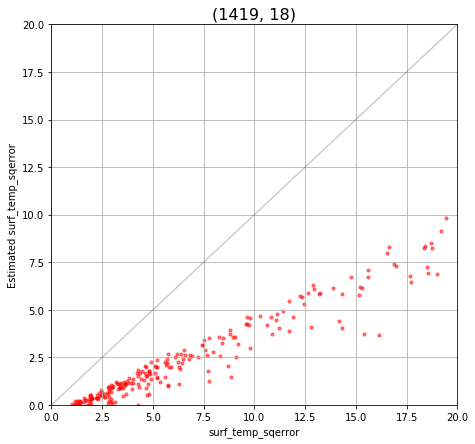

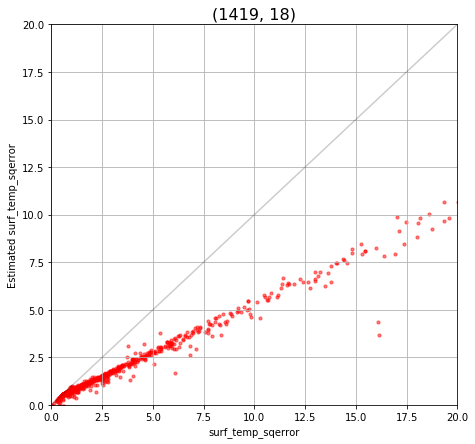

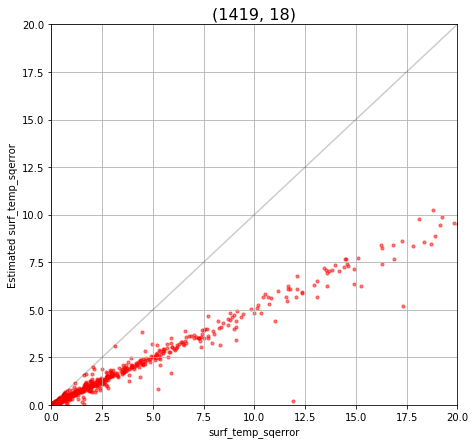

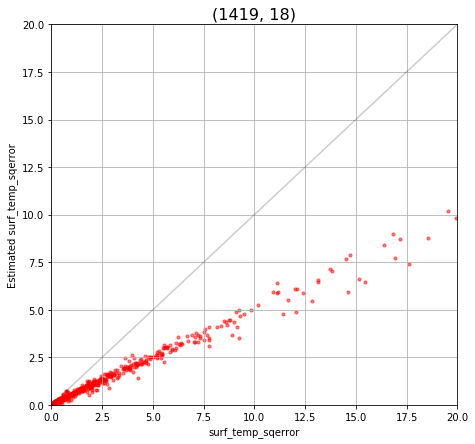

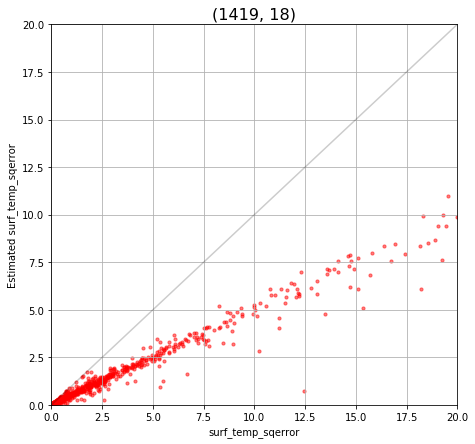

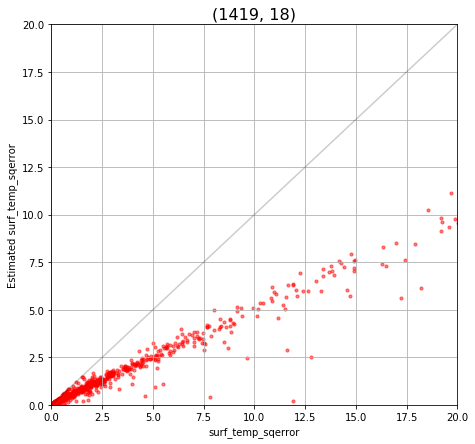

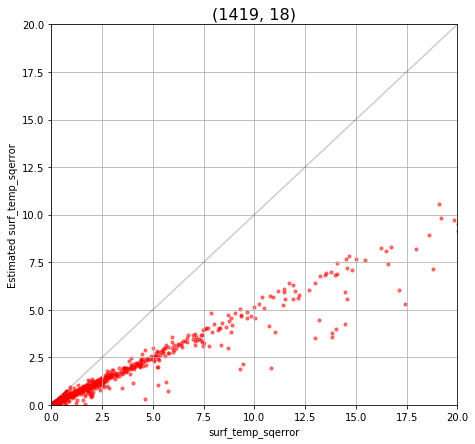

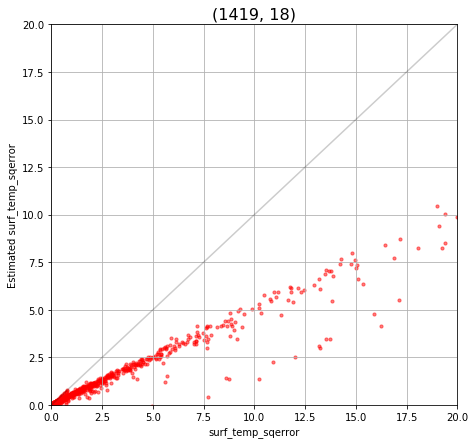

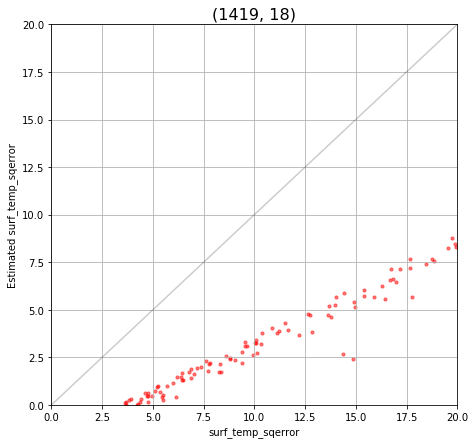

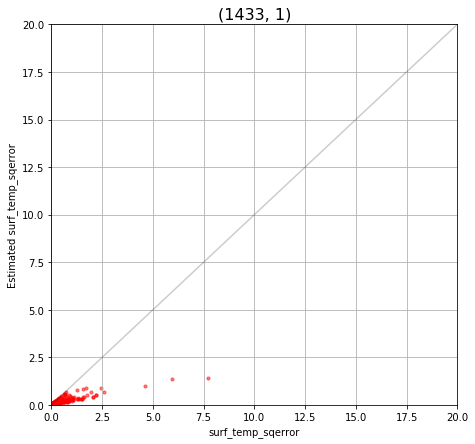

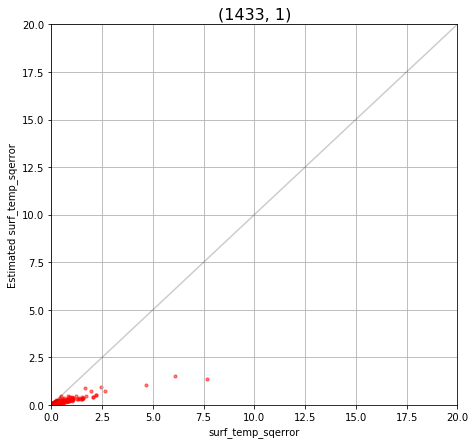

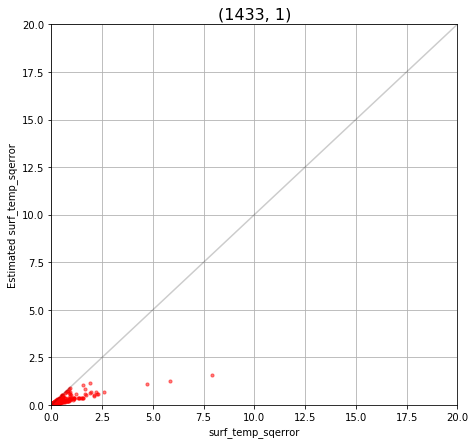

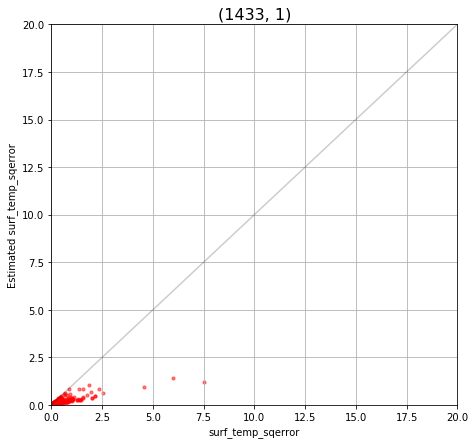

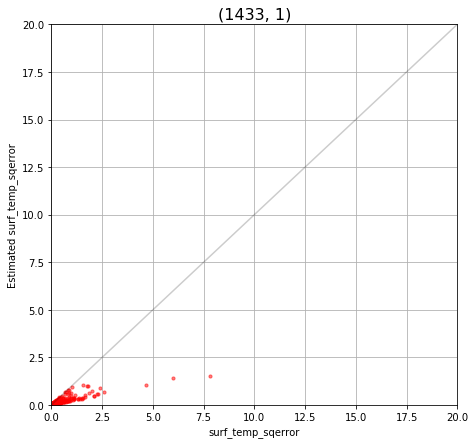

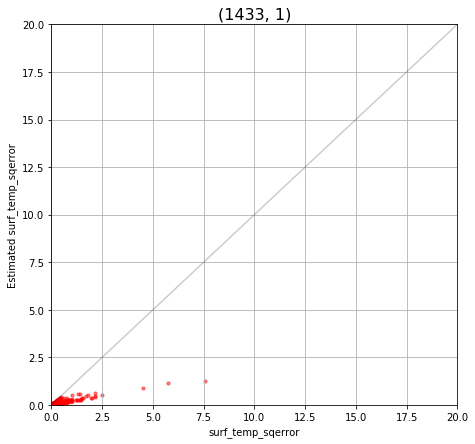

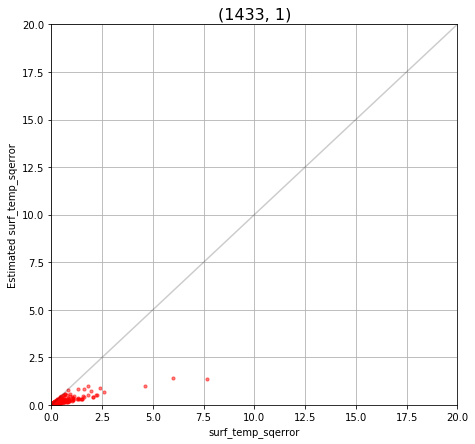

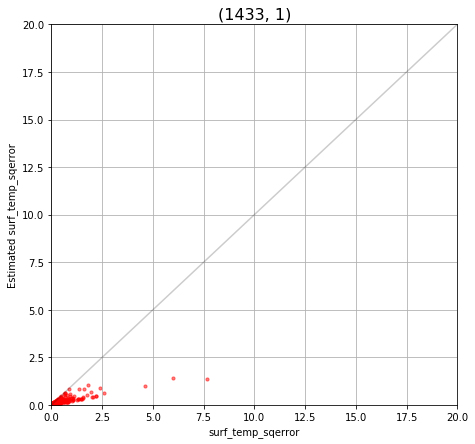

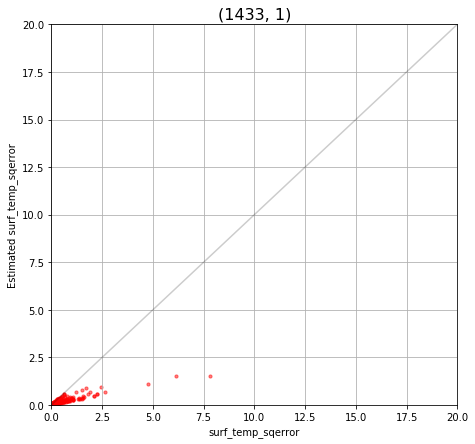

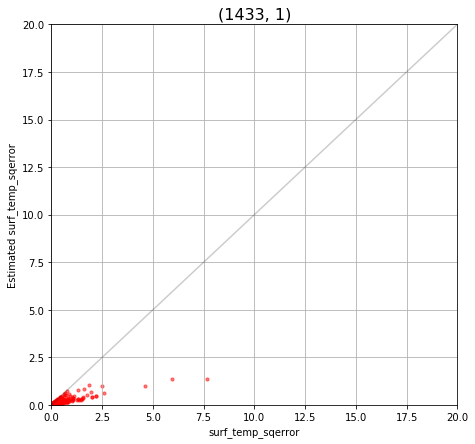

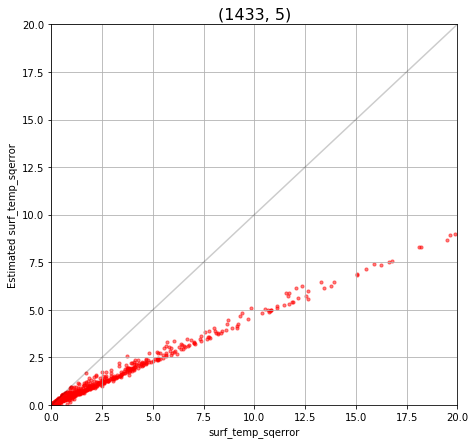

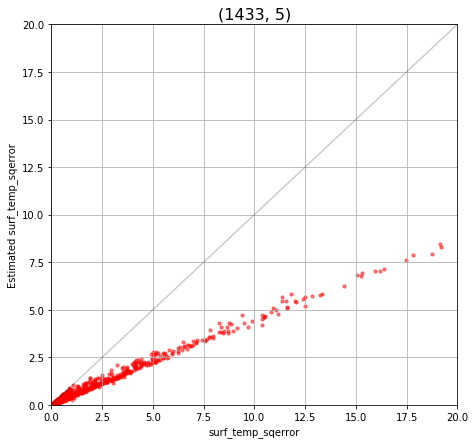

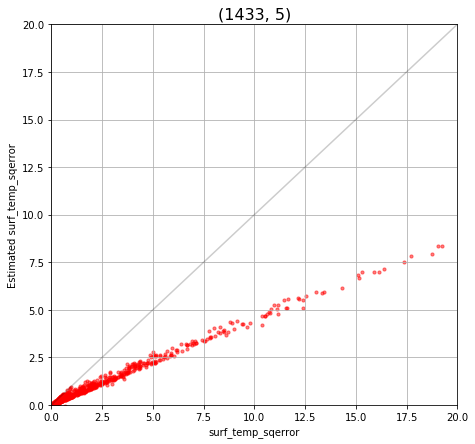

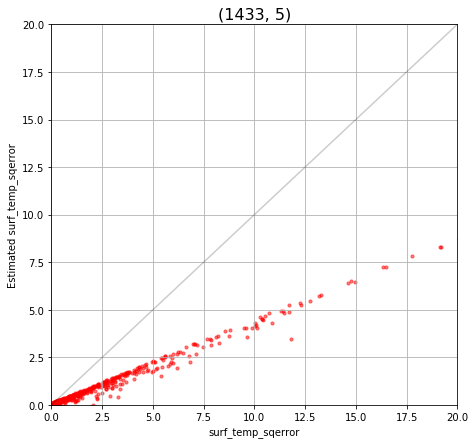

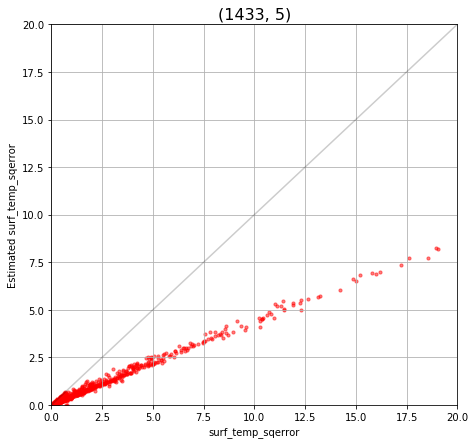

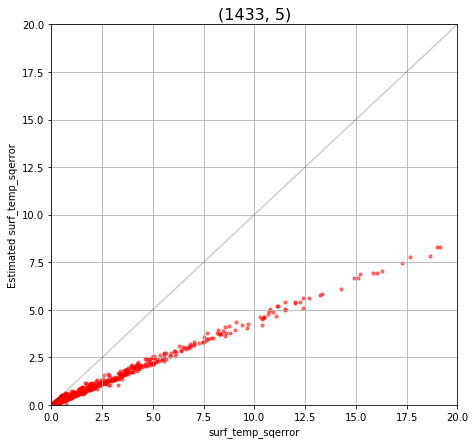

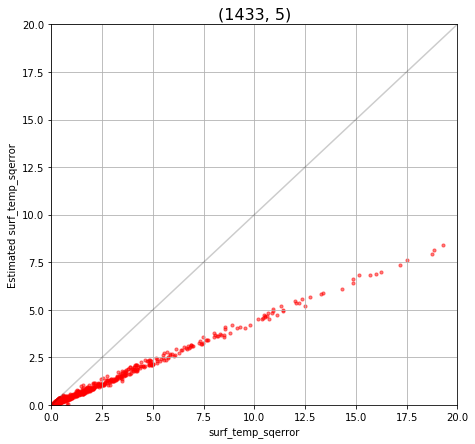

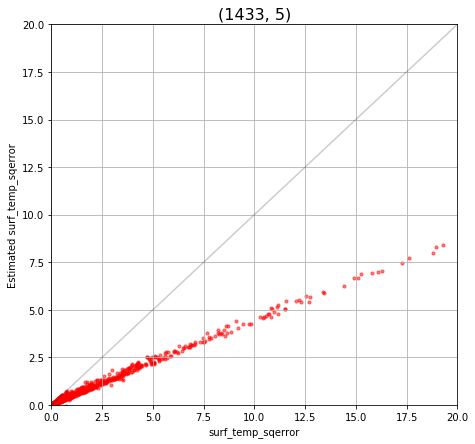

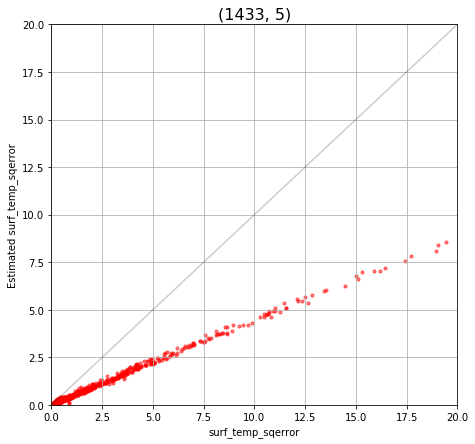

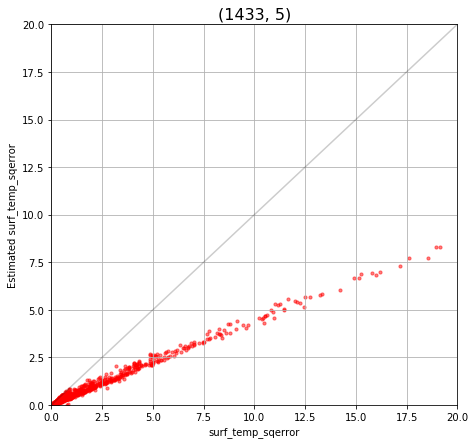

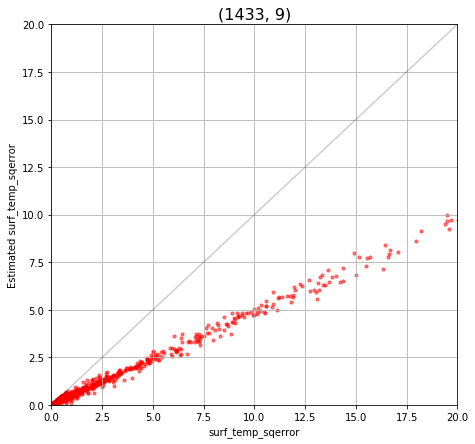

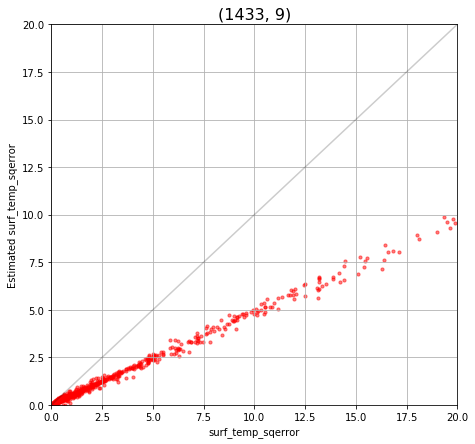

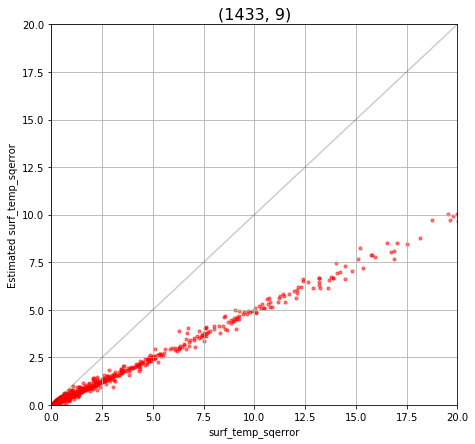

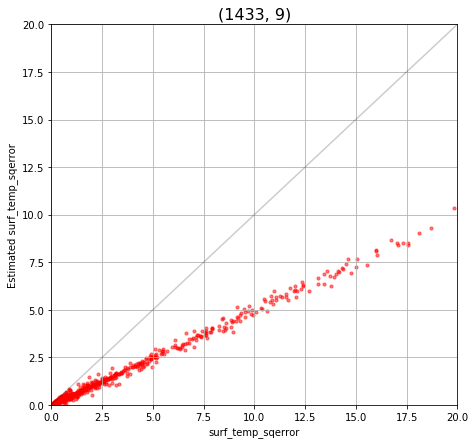

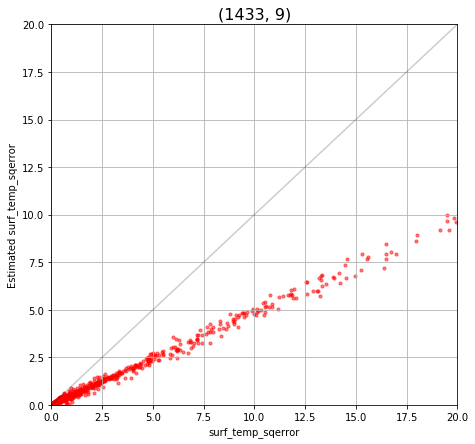

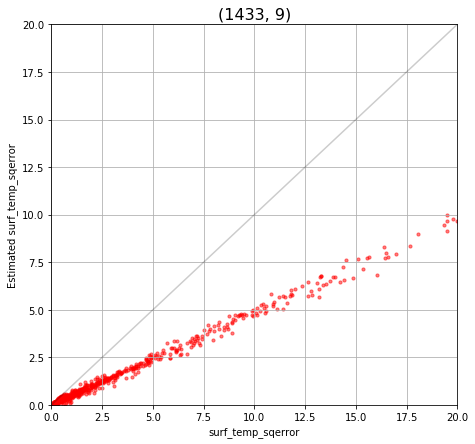

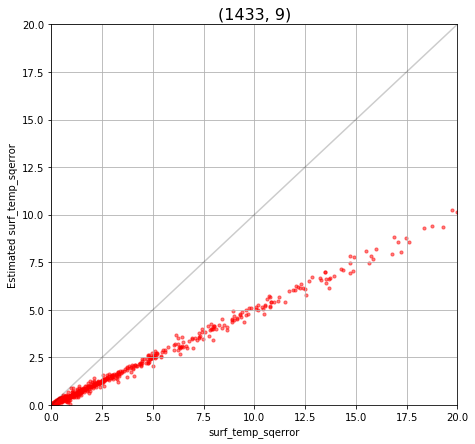

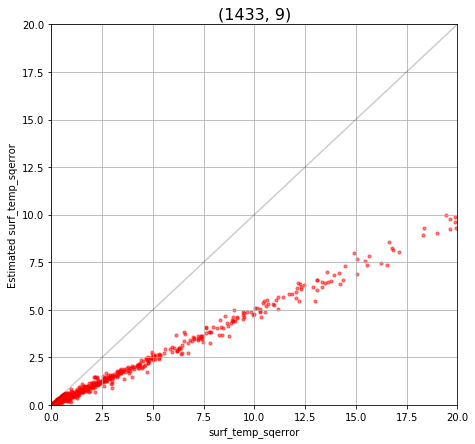

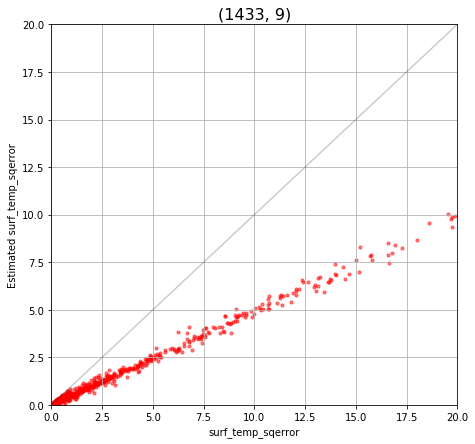

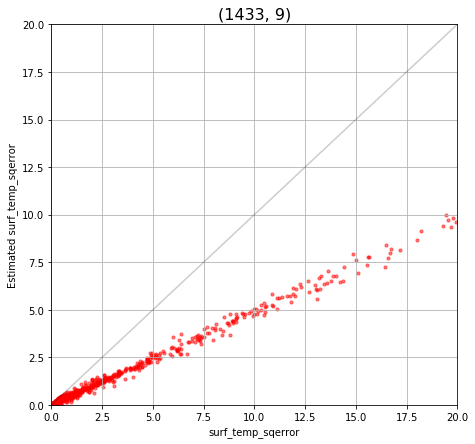

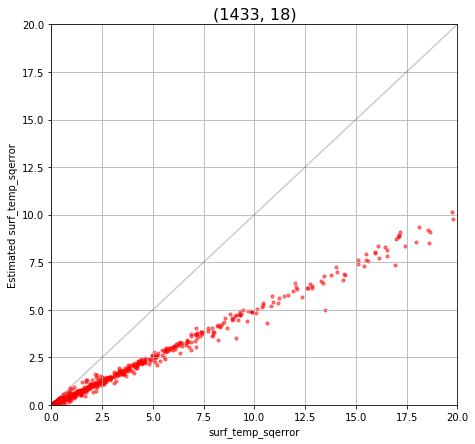

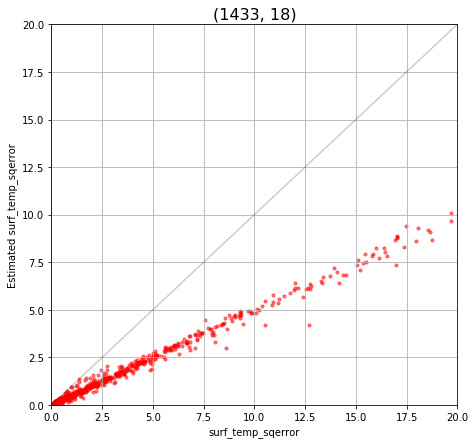

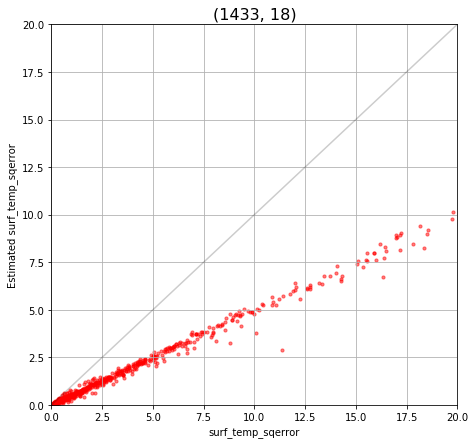

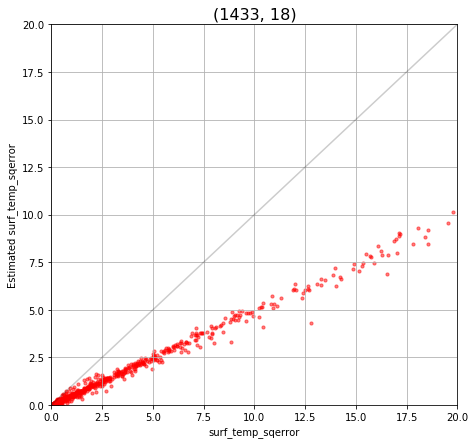

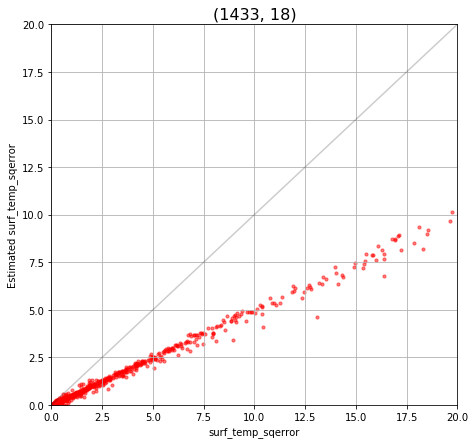

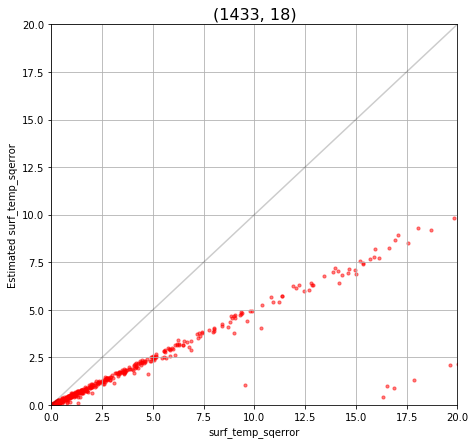

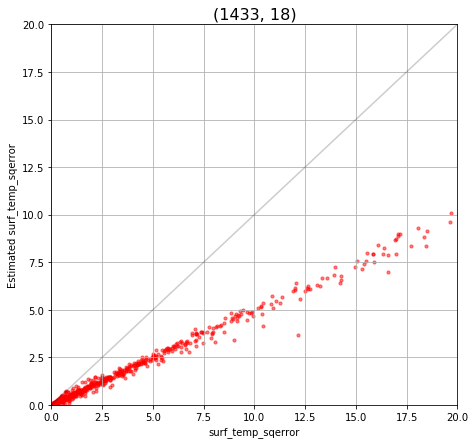

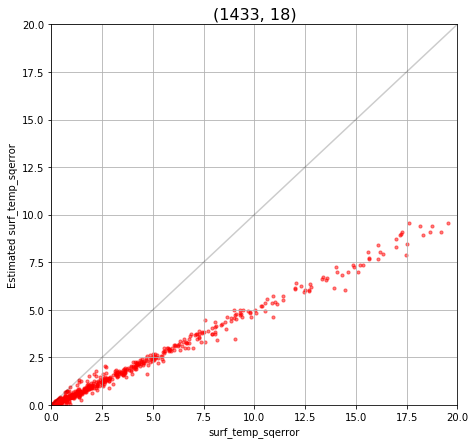

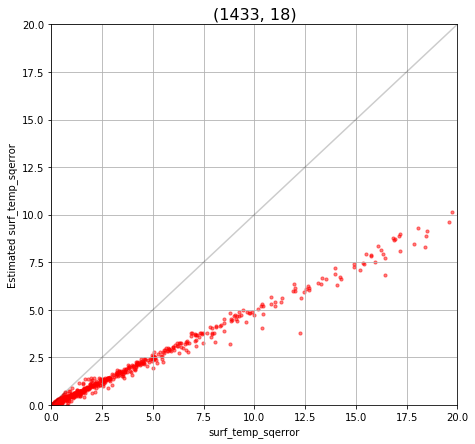

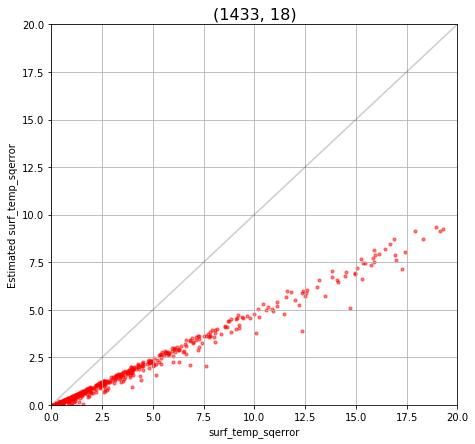

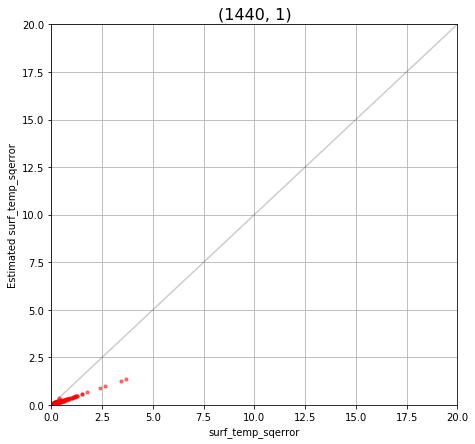

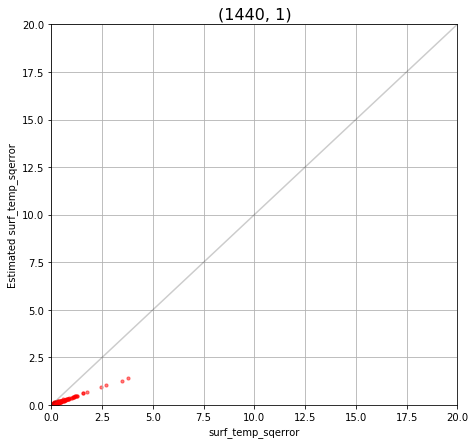

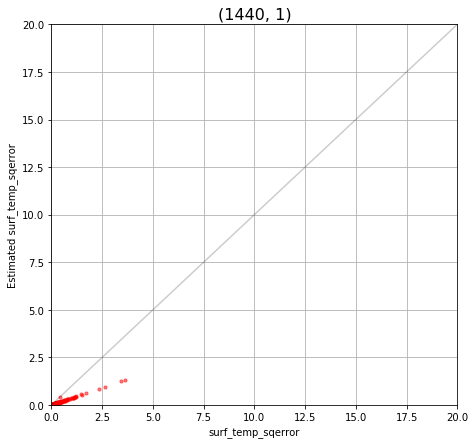

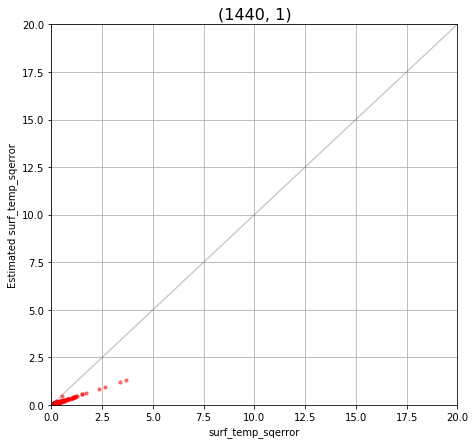

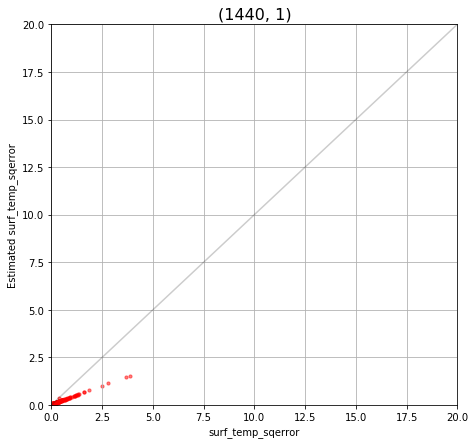

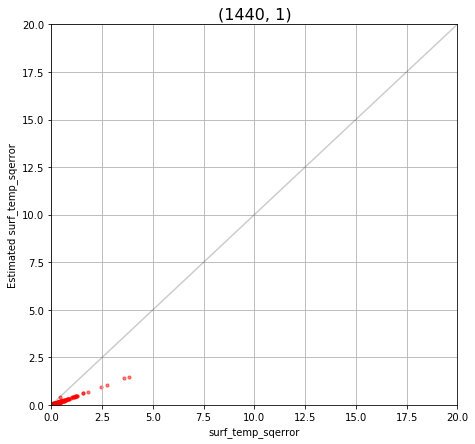

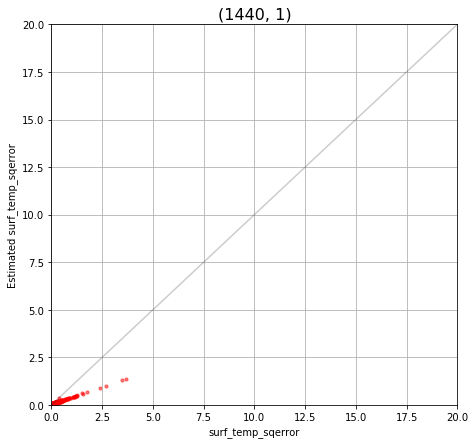

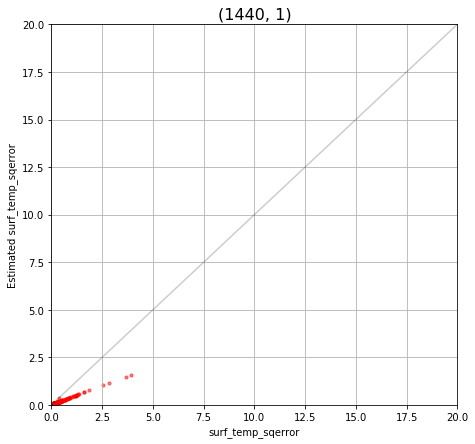

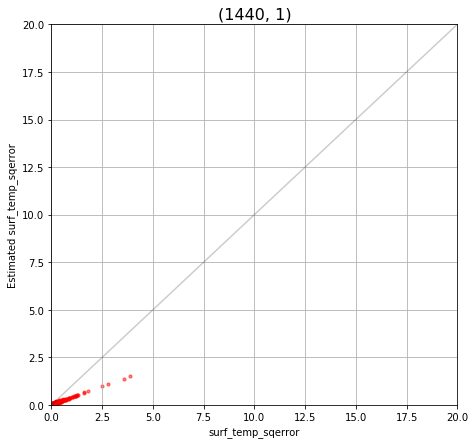

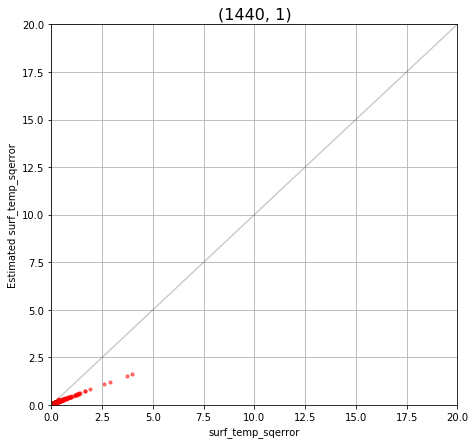

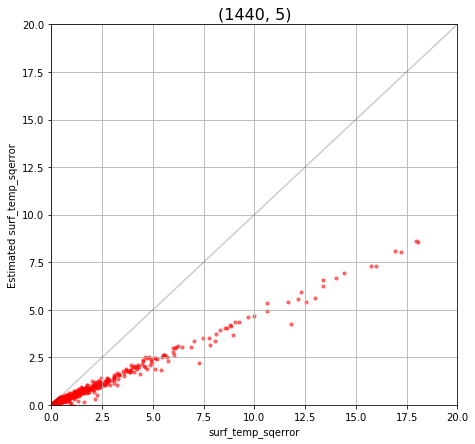

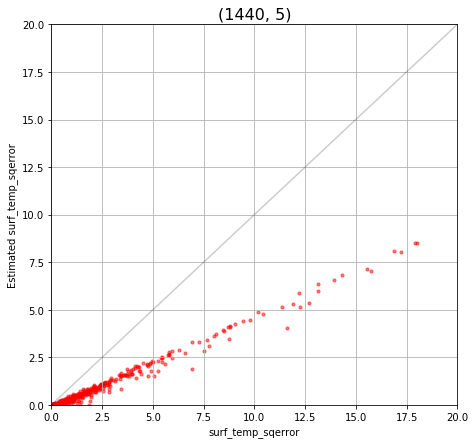

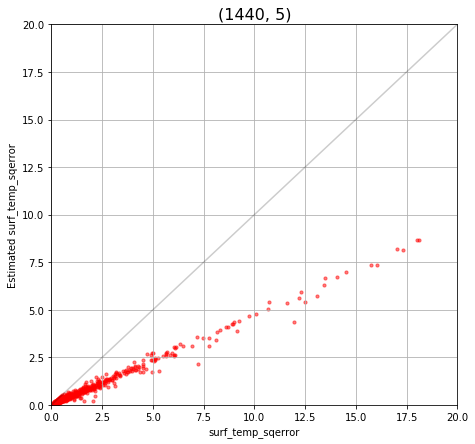

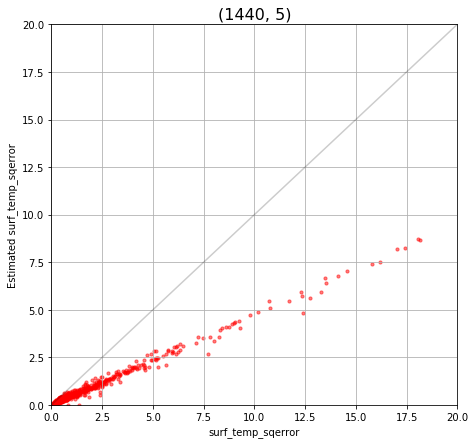

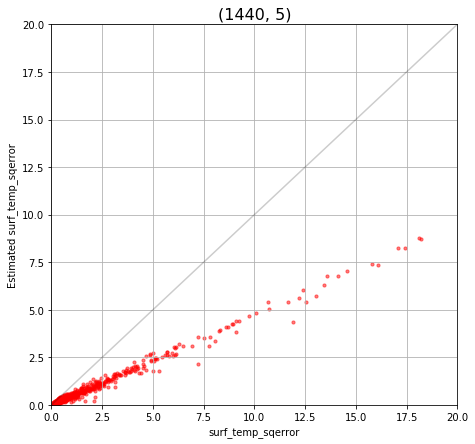

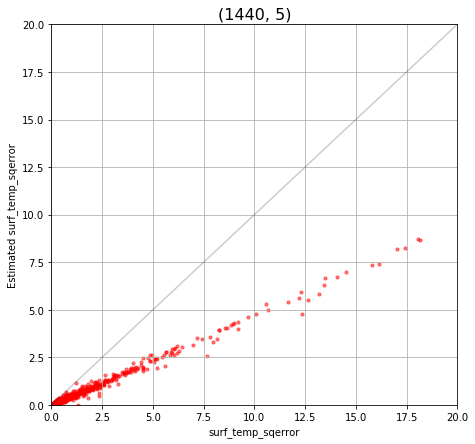

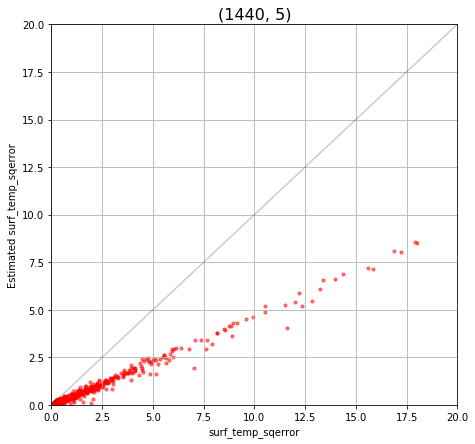

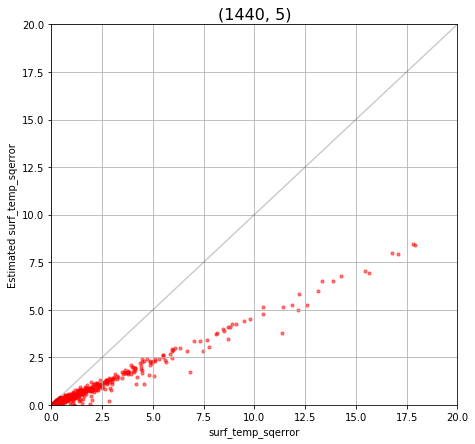

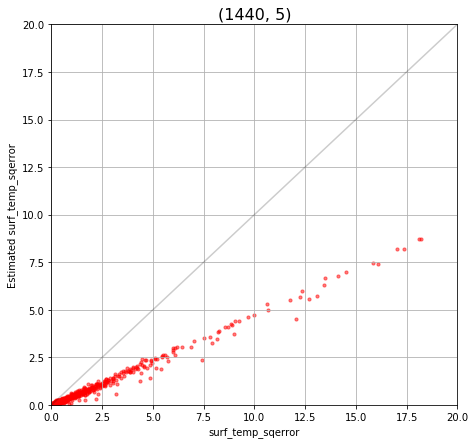

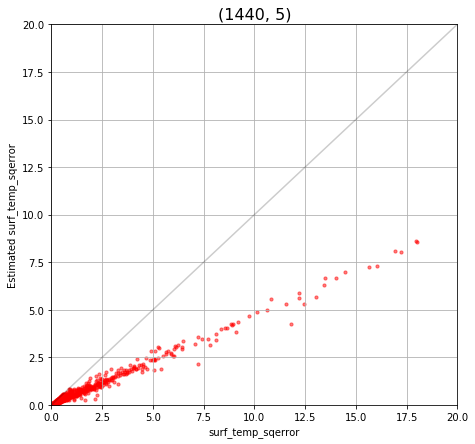

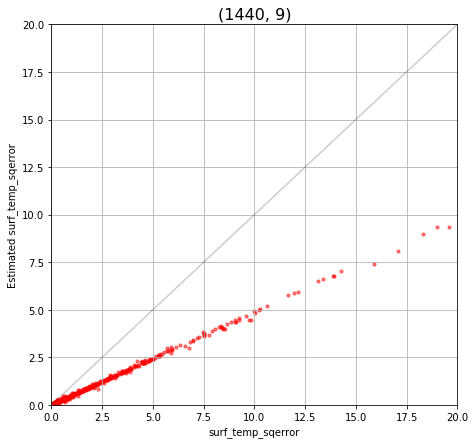

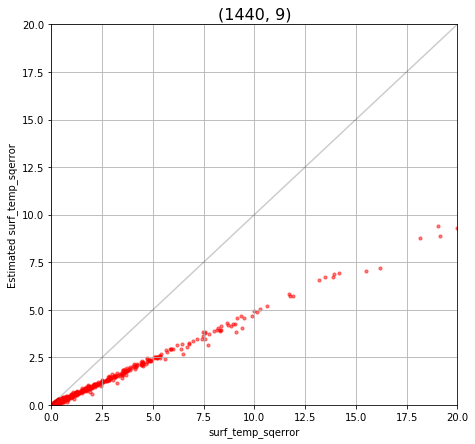

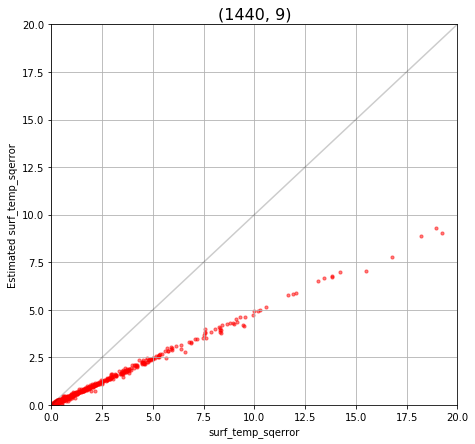

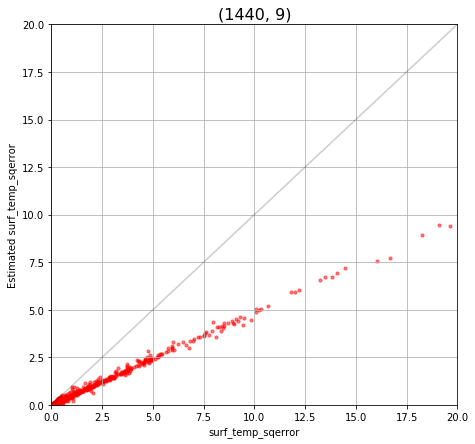

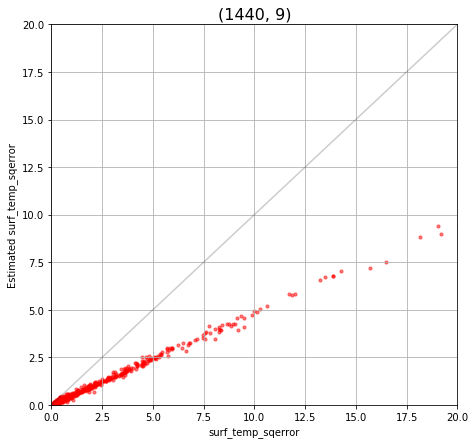

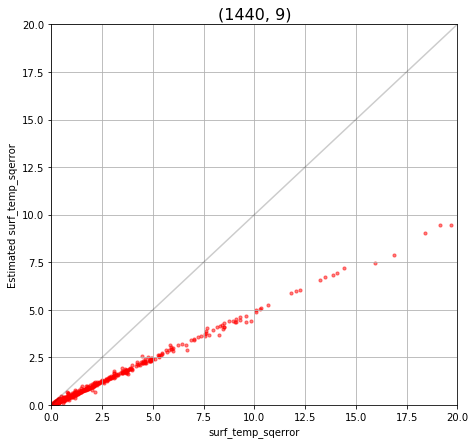

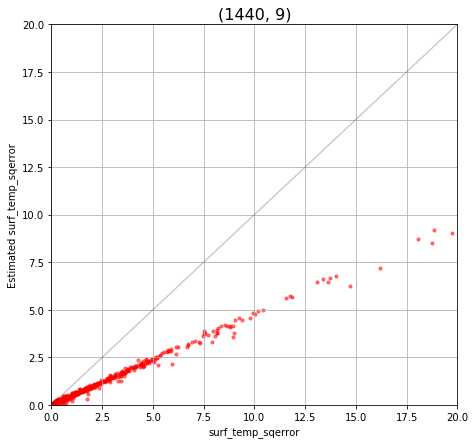

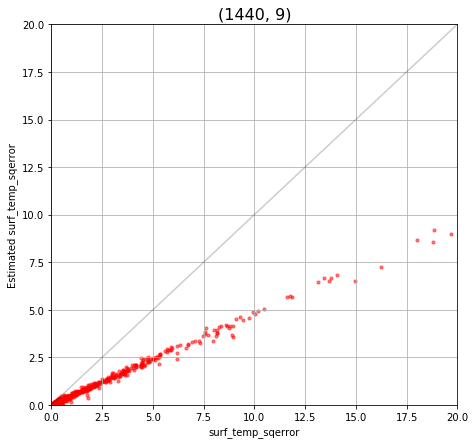

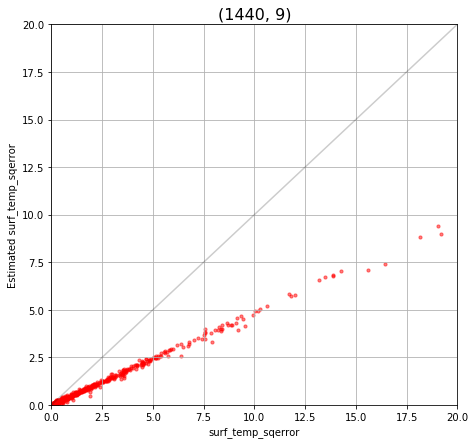

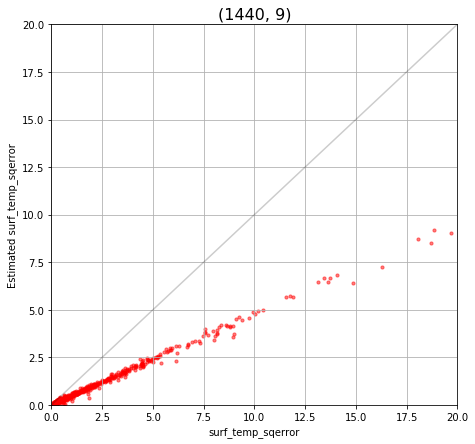

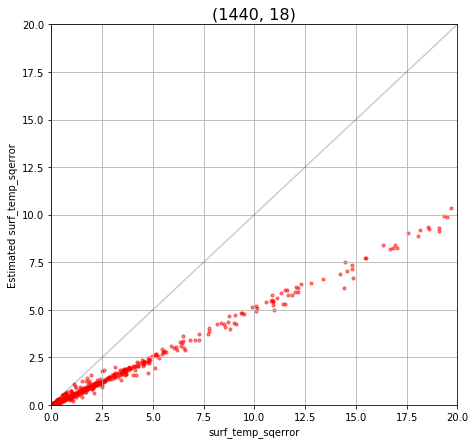

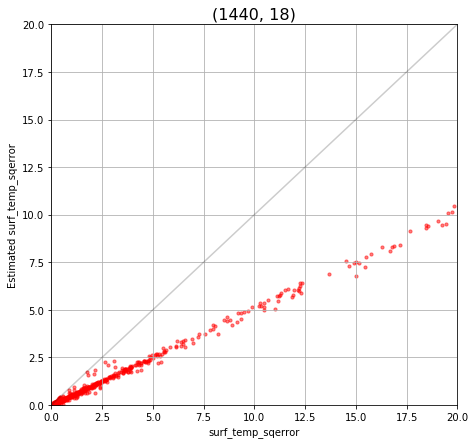

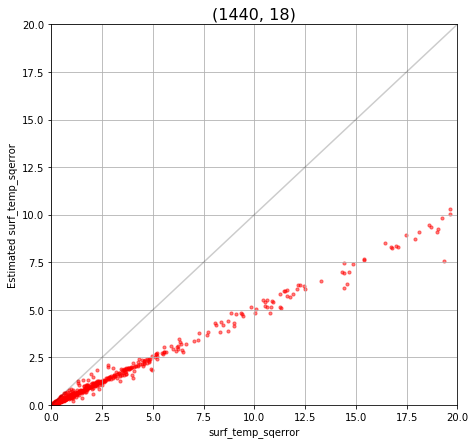

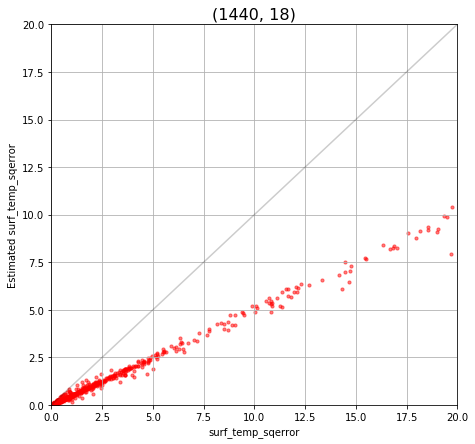

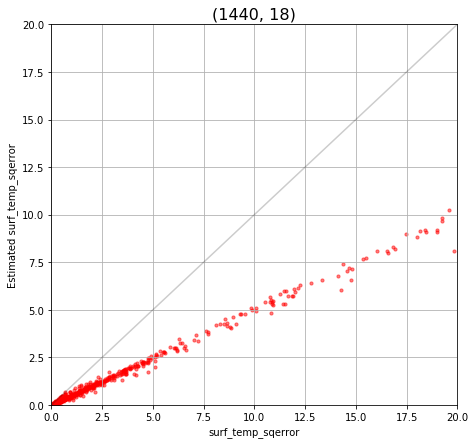

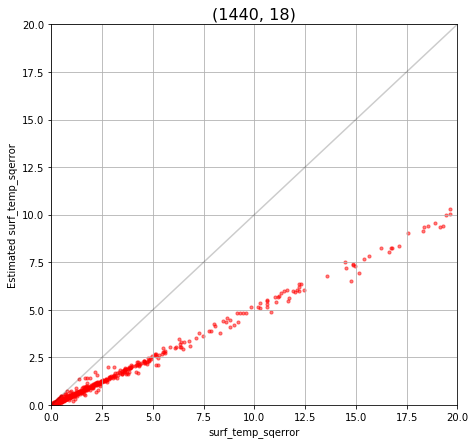

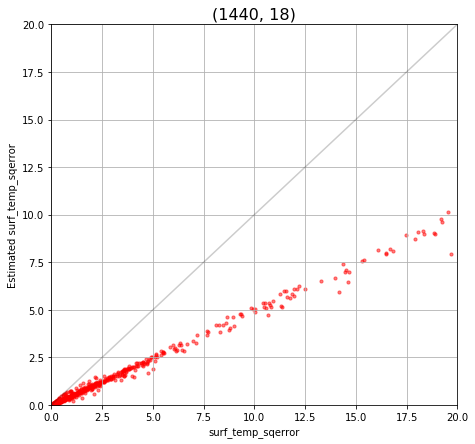

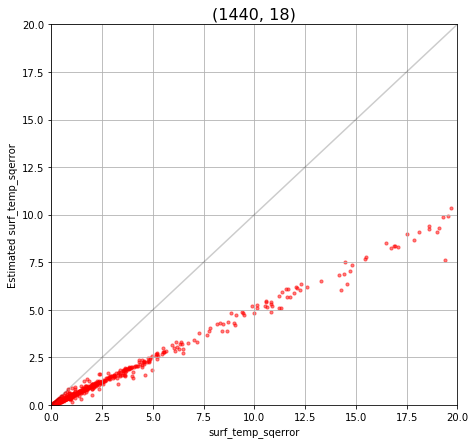

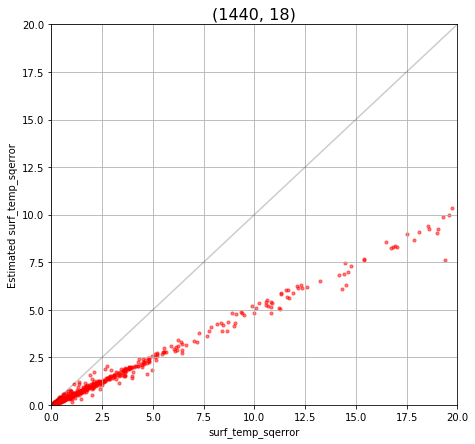

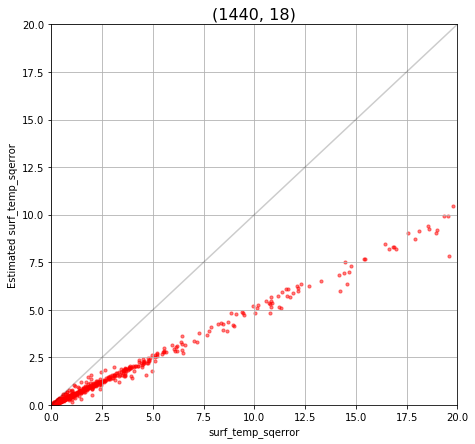

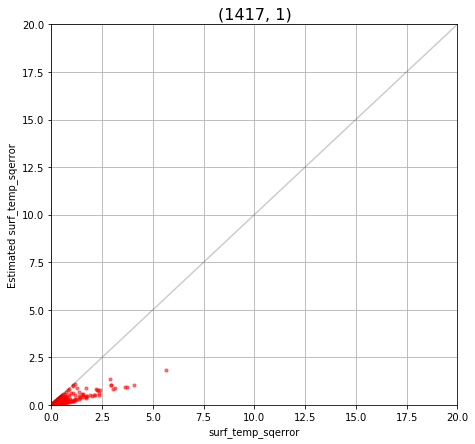

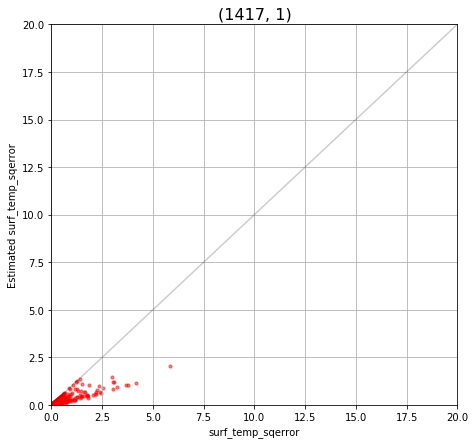

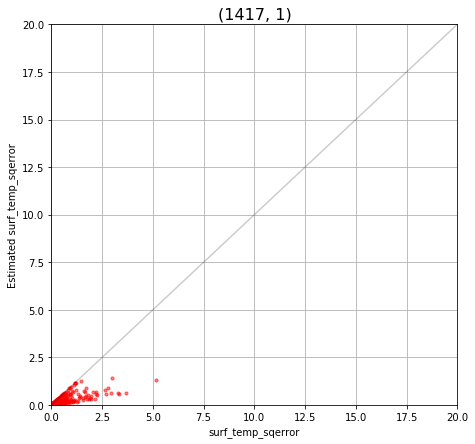

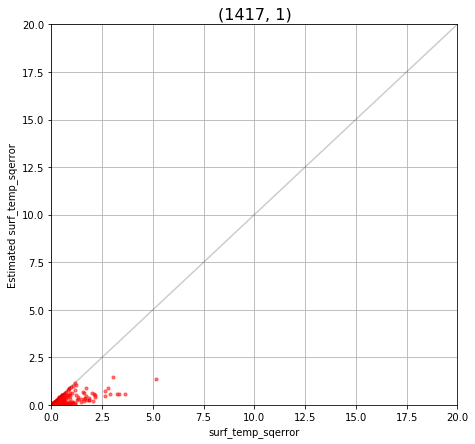

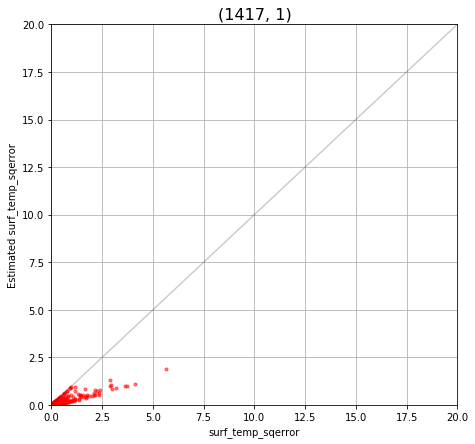

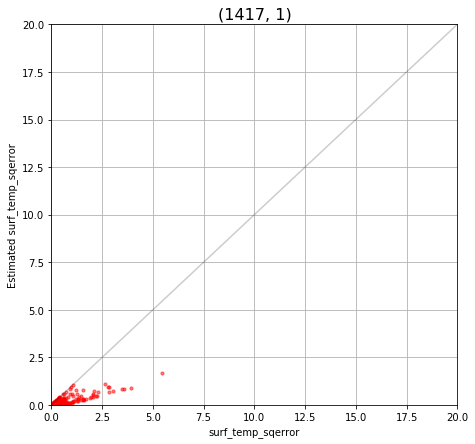

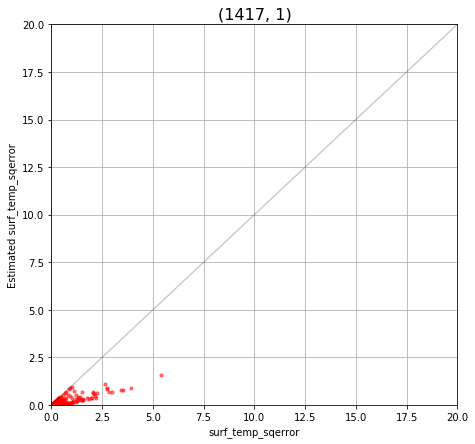

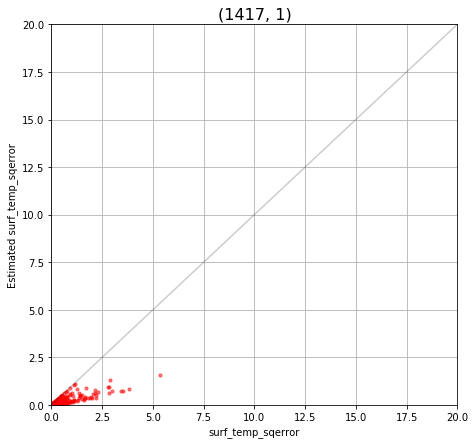

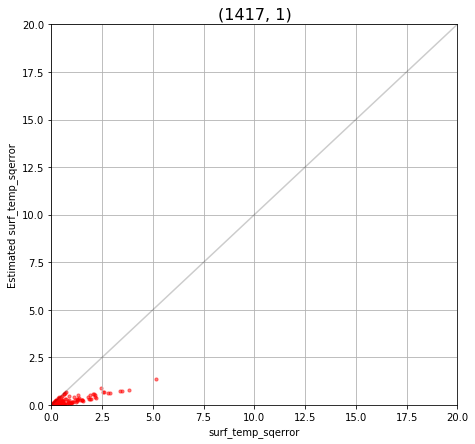

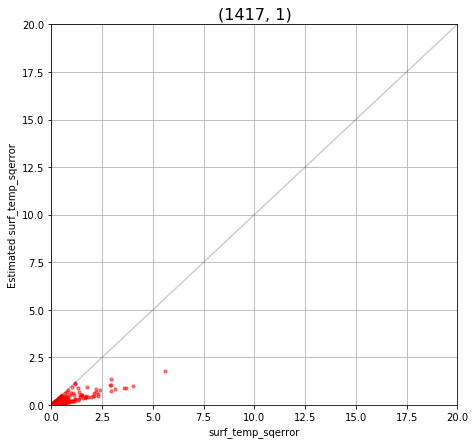

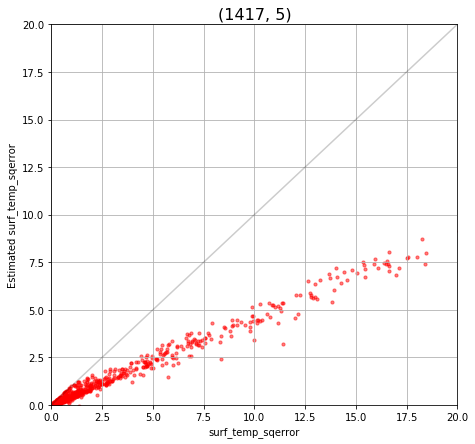

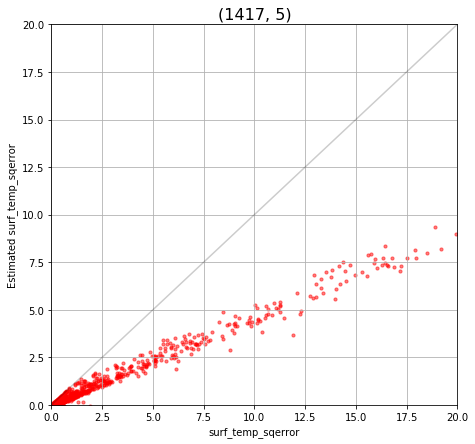

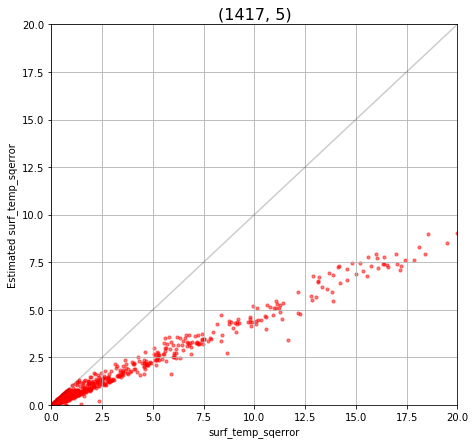

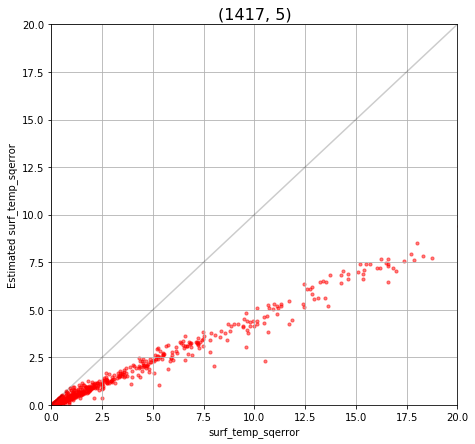

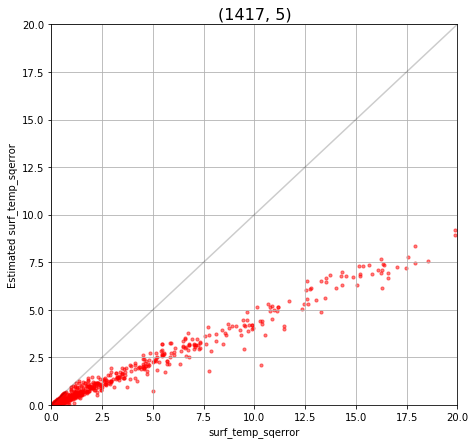

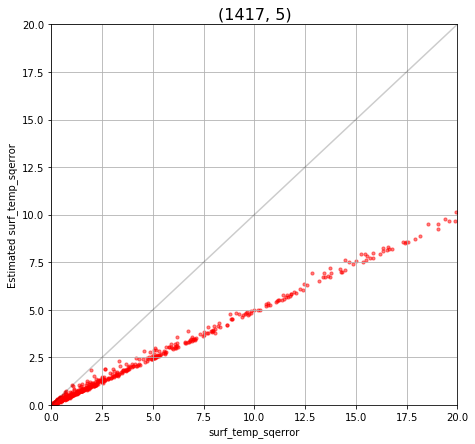

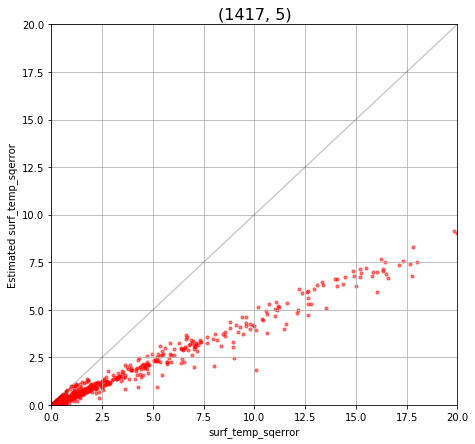

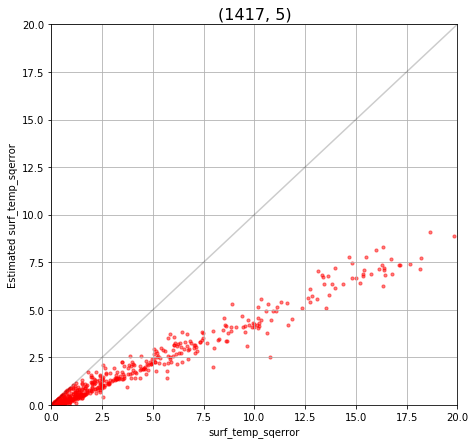

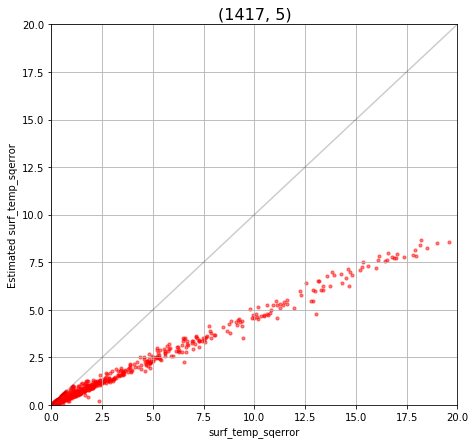

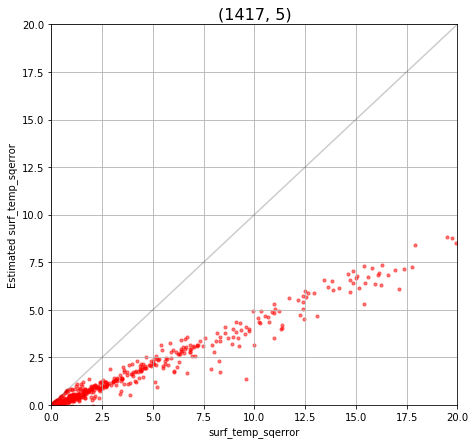

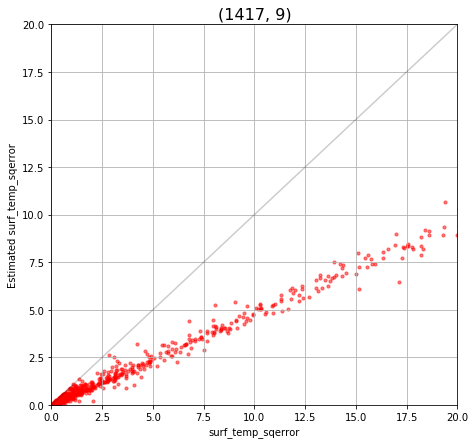

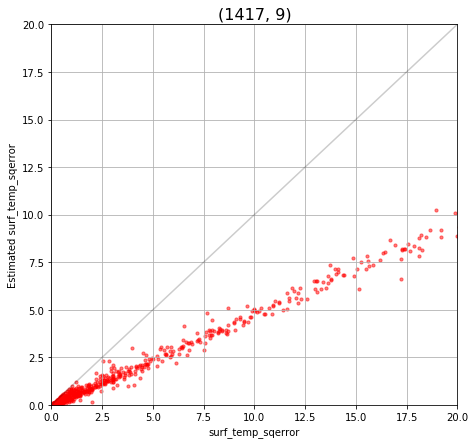

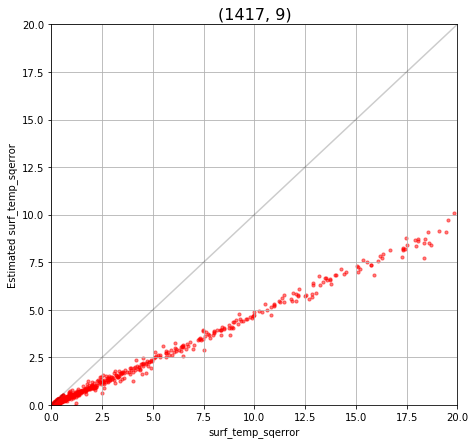

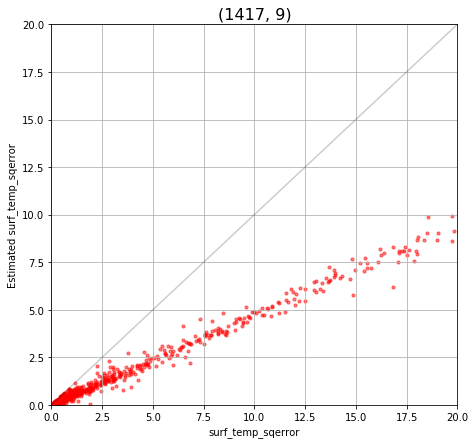

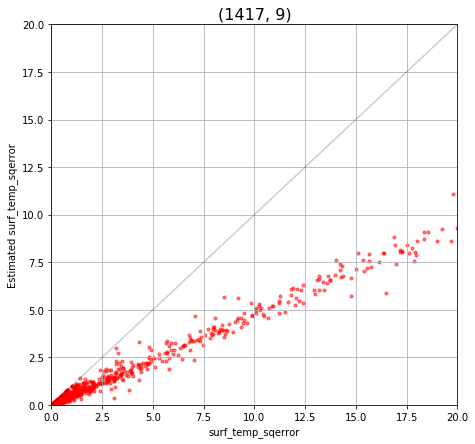

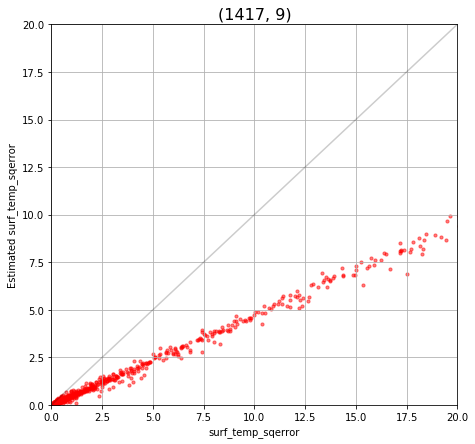

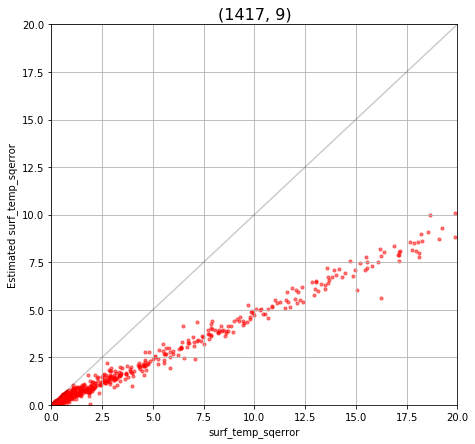

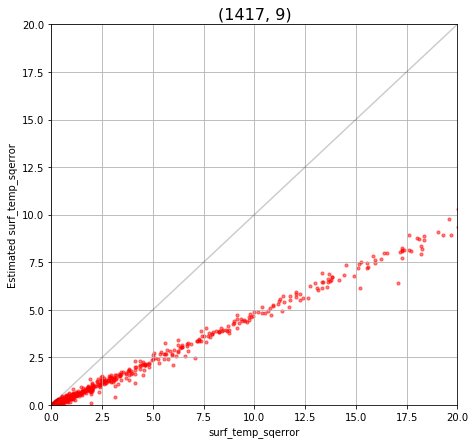

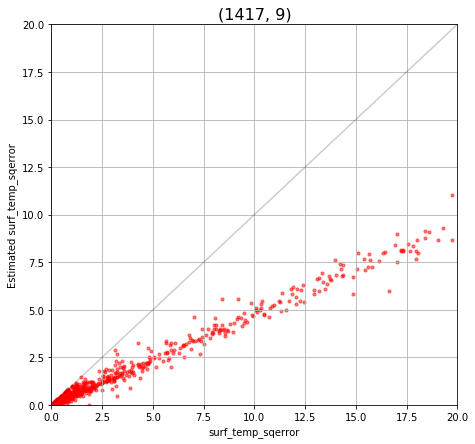

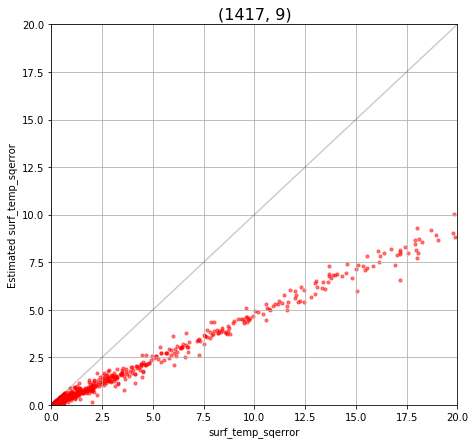

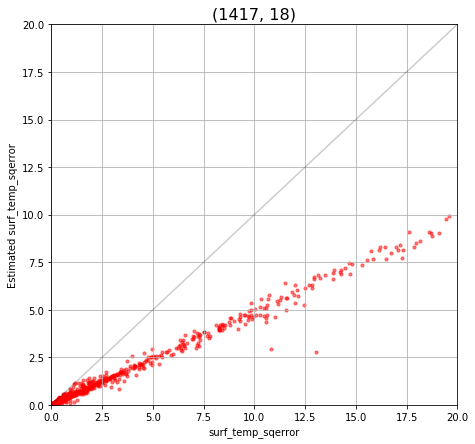

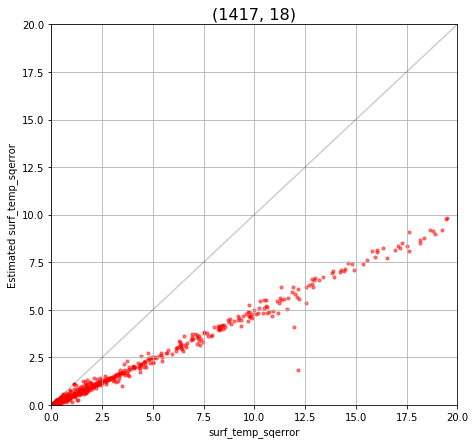

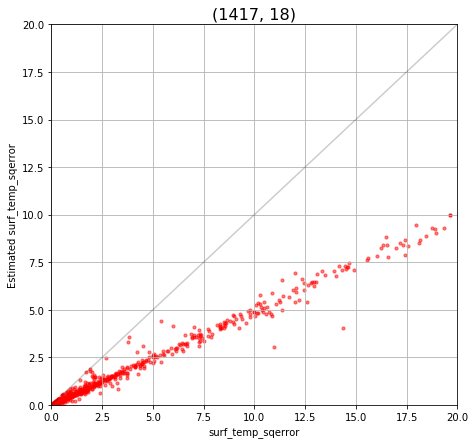

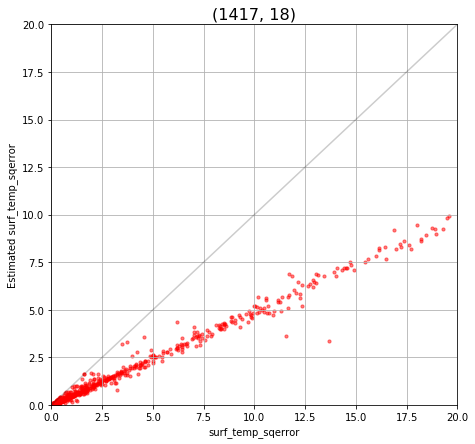

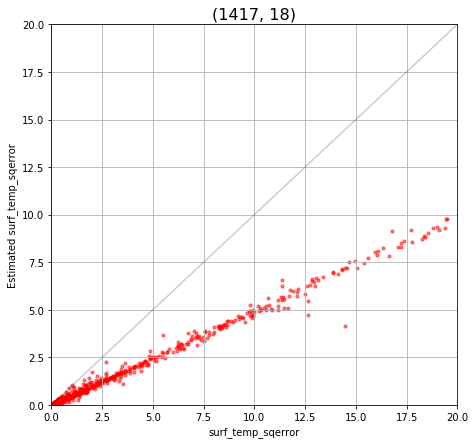

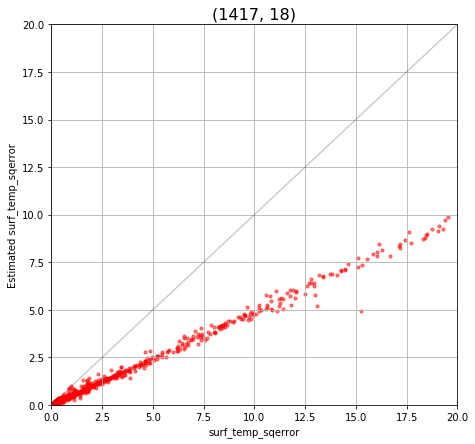

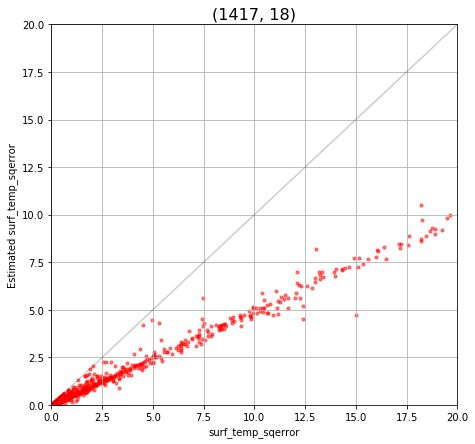

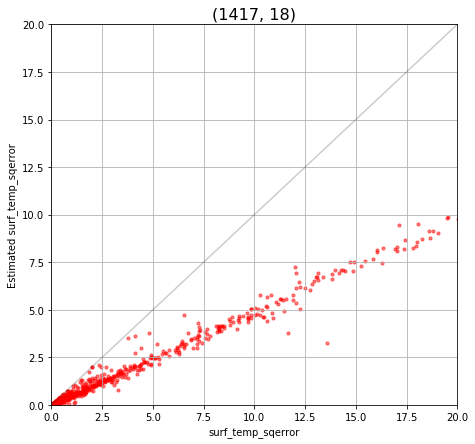

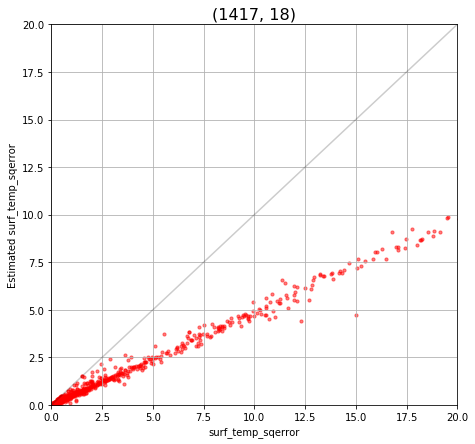

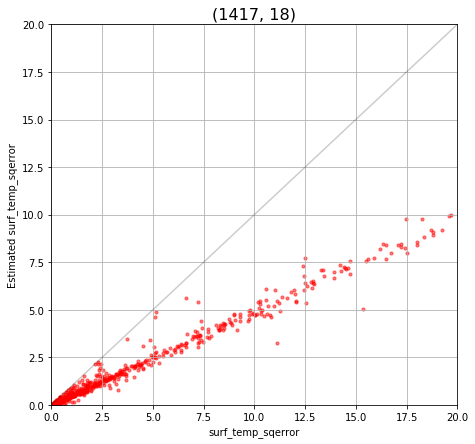

In [16]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

repeats = 10
features = 1
results = dict()
timesteps = 1

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        results[key] = experiment(repeats, df[key], features, timesteps, key)
    

In [163]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results/rnn/data_{}.csv".format(str(key)))

    with open("results/rnn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)